In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.distributions import beta
from scipy.special import beta as beta_func

In [3]:
def get_shape(omega, kappa):
    return omega*(kappa-2)+1 , (1-omega)*(kappa-2)+1

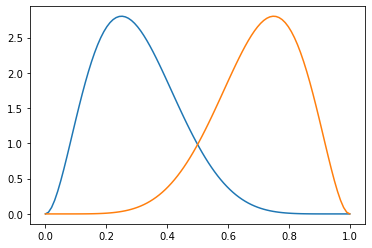

In [5]:
omega1 = 0.25
omega2 = 0.75
kappa =10

thetas = np.linspace(0,1,100)

a1, b1 = get_shape(omega1, kappa)
plt.plot(thetas, beta.pdf(thetas, a1,b1), label='factory1')

a2, b2 = get_shape(omega2, kappa)
plt.plot(thetas, beta.pdf(thetas, a2,b2), label='factory2');

In [6]:
def marginal_likelihood(z, N, omega, kappa):
    a, b = get_shape(omega, kappa)
    return beta_func(z+a, N-z+b) / beta_func(a,b)

In [7]:
N=10
z=6

In [8]:
p_M1 = marginal_likelihood(z,N,omega1,kappa)
p_M2 = marginal_likelihood(z,N,omega2,kappa)
print(p_M1, p_M2)

0.00030310247028513286 0.000714455822814956


In [9]:
bayes_factor_M1M2 = p_M1/p_M2
print(bayes_factor_M1M2)

0.4242424242424242


In [10]:
import pymc3 as pm

In [12]:
with pm.Model() as model:
    model_index = pm.DiscreteUniform('model_index', lower=1, upper=2)
    
    omega = pm.math.switch(pm.math.eq(model_index, 1), omega1, omega2)
    
    a = omega* (kappa -2) + 1
    b = (1-omega) * (kappa-2) +1
    theta = pm.Beta('theta', a, b)
    
    y = pm.Binomial('y', n=N , p=theta, observed=z)

INFO (theano.gof.compilelock): Waiting for existing lock by process '249' (I am process '905')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-4.19-linuxkit-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir


In [13]:
with model:
    trace = pm.sample(5000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [model_index]
>NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|██████████| 5500/5500 [00:18<00:00, 301.75it/s]
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
model_index,1.712,0.453,1.000,2.00,0.015,0.011,903.0,903.0,903.0,903.0,1.0
theta,0.593,0.140,0.324,0.83,0.004,0.003,1364.0,1364.0,1479.0,3072.0,1.0


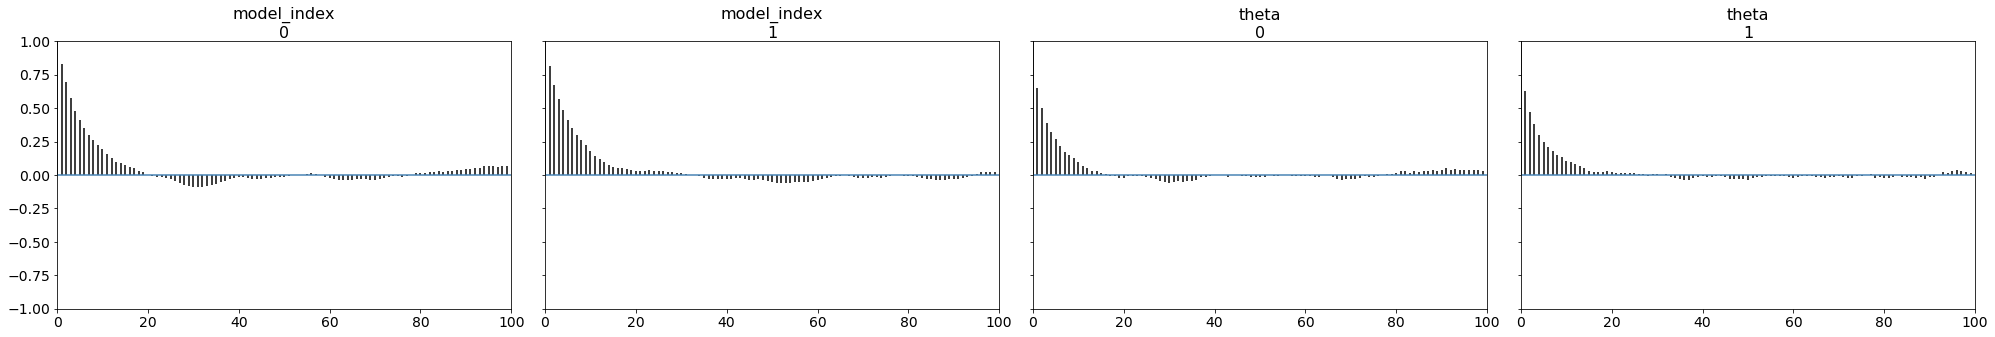

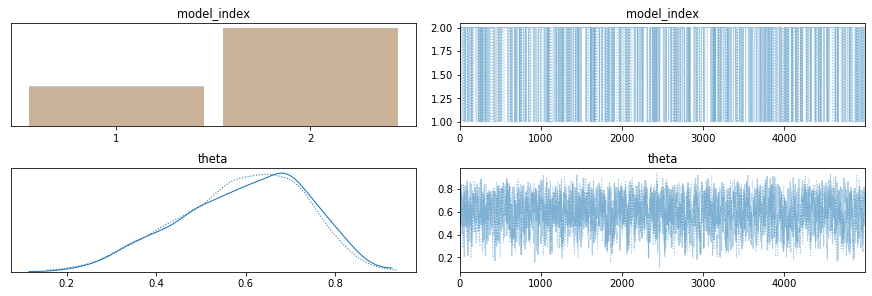

In [14]:
pm.autocorrplot(trace)
pm.traceplot(trace)
pm.summary(trace)


In [15]:
model_idx_sample = trace['model_index']

p_M1 = np.count_nonzero(model_idx_sample == 1) / len(model_idx_sample)
p_M2 = 1 - p_M1
print(p_M1, p_M2)

0.288 0.712


In [17]:
theta_sample = trace['theta']

theta_sample_M1 = theta_sample[model_idx_sample ==1]
theta_sample_M2 = theta_sample[model_idx_sample ==2]

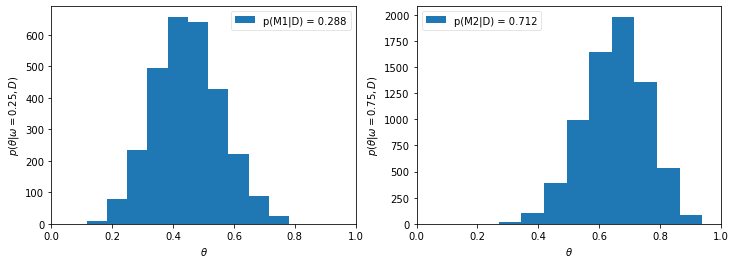

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(theta_sample_M1, label='p(M1|D) = {:.3f}'.format(p_M1))
axs[0].set_ylabel(r'$p(\theta|\omega=0.25,D)$')
axs[0].legend(loc='upper right', framealpha=0.5)

axs[1].hist(theta_sample_M2, label='p(M2|D) = {:.3f}'.format(p_M2))
axs[1].set_ylabel(r'$p(\theta|\omega=0.75,D)$')
axs[1].legend(loc='upper left', framealpha=0.5)

for ax in axs:
    ax.set_xlabel(r'$\theta$')
    ax.set_xlim(0, 1);